#### This notebook solves a household problem in a deterministic growth economy using am MPEC method.
Model
--
The household chooses its consumption and savings while being constraint by its budget set. Saved capital is used for production next period. Produced goods and leftover capital are returned to the household.

The sequence problem:
$$\underset{ \left(c_t, k_{t+1}\right)_{t=0}^\infty } {max} \sum_{t=0}^\infty \beta^t \, u( c_t )$$
s.t.
$$k_{t+1} = f(k_t) + (1-\delta) k_t - c_t \quad \forall t$$
$$k_0 \, \text{given}$$

can be written recursively as:

$$V(k) = \underset{ c } {max} \, u( c ) + \beta \, V \big( f(k) + (1-\delta) k -c \big)$$
The solution of this Bellman equation is a policy function $c(k)$ for consumption.

Using the first-order condition and the envelope theorem yields:
$$u'\Big(\Psi(k) \cdot \theta\Big) =\beta \, u'\Big( \Psi \big( f(k) +(1- \delta)k- \Psi(k) \cdot \theta\big)\cdot \theta \Big)  \, \Big( f'\big(f(k) +(1- \delta)k - \Psi(k) \cdot \theta \big) + (1-\delta) \Big)\quad\forall k$$


Numerical Method
--


## Collocation Method and Simulation

In [1]:
using Parameters
using BasisMatrices
using LaTeXStrings
using Plots; pyplot();

In [9]:
@with_kw immutable GrowthModel
    β::Float64                           # discount factor
    δ::Float64                           # depreciation of capital
    α::Float64                           # capital share
    A::Float64                           # productivity
    γ::Float64                           # RRA
end

model = GrowthModel(β = 0.95, δ = 0.05, α = 0.3, A = 1, γ = 2)

function steady_state_k(model::GrowthModel)
    @unpack β, α, A, δ = model
    ((1/β-(1-δ))/(A*α))^(1/(α-1))
end

function f(model::GrowthModel, k)
    @unpack α, A, δ = model
    A*k.^α
end

function f_prime(model::GrowthModel, k)
    @unpack α, A, δ = model
    A*α*k.^(α-1)
end

u_crra_prime(c, γ) = c.^-γ
u_crra(c, γ) = c.^(1-γ)/(1-γ)
u_crra_prime_inv(u, γ) = u.^(-1/γ)

u_crra_prime_inv (generic function with 1 method)

In [3]:
k_stst = steady_state_k(model)

4.628988089138438

In [4]:
function solve_and_simulate(model, N; k0=1.)
    @unpack β, α, A, δ, γ = model
    
    #solve

    k_stst = steady_state_k(model)

    basis = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))

    Ψ = BasisMatrix(basis, Expanded()).vals[1]
    K = nodes(basis)[1]

    a = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    a_old = zeros(a)
    
    stop = false
    
    @time while !stop

        a_old = a
    
        Y = u_crra_prime_inv(β*u_crra_prime(BasisMatrix(basis, Expanded(), f(model,K) + (1-δ)*K - Ψ*a).vals[1]*a, γ) .* 
                (f_prime(model, f(model,K) + (1-δ)*K - Ψ*a) + 1-δ), γ)

        a = Ψ \ Y

        if maximum(abs.(u_crra_prime(Y, γ)./u_crra_prime(Ψ*a_old, γ) - 1)) < 1e-10
            stop = true
        end
    end
    
    #simulate
    simK = zeros(N)
    simC = zeros(N)
    
    simK[1] = k0
    
    
    for t in 1:N-1
        simC[t] = (BasisMatrix(basis, Expanded(), [simK[t]]).vals[1] * a)[1]
        simK[t+1] = f(model,simK[t]) + (1-δ)*simK[t] - simC[t]
    end
    
    simC[N] = (BasisMatrix(basis, Expanded(), [simK[N]]).vals[1] * a)[1]
    
    return (simK, simC, a)
end


solve_and_simulate (generic function with 1 method)

In [5]:
(dataK, dataC, true_coeff) = solve_and_simulate(model, 100; k0=1.)
true_coeff

  0.109033 seconds (10.03 k allocations: 1.933 MiB)


10-element Array{Float64,1}:
  1.35054    
  0.544286   
 -0.0634735  
  0.0167686  
 -0.00554682 
  0.00203287 
 -0.000791507
  0.000351972
 -0.000172349
  5.71702e-5 


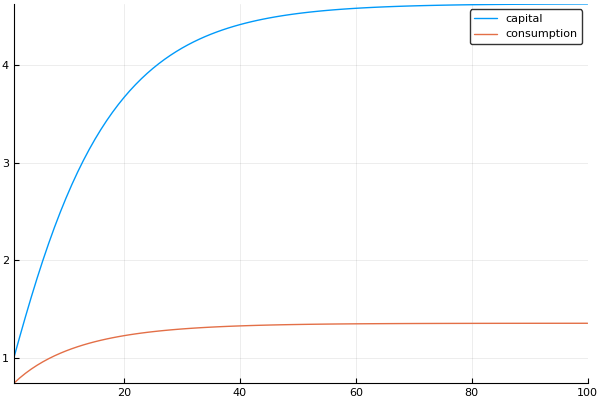

In [6]:
plot(dataK, label="capital")
plot!(dataC, label="consumption")

In [7]:
basis = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
K = nodes(basis)[1]
Ψ = BasisMatrix(basis, Expanded()).vals[1]
f(model,K) + (1-model.δ)*K - Ψ * true_coeff

10-element Array{Float64,1}:
 1.19027
 1.58223
 2.31211
 3.30116
 4.45398
 5.66037
 6.80466
 7.77679
 8.48254
 8.85344

In [25]:
Ψ * true_coeff

10-element Array{Float64,1}:
 0.731039
 0.830067
 0.984055
 1.15697 
 1.32812 
 1.48555 
 1.62093 
 1.72778 
 1.80161 
 1.8393  

In [23]:
ν = zeros(10)

for t in 1:10000
    ν = Ψ \ (u_crra(Ψ * true_coeff, model.γ) + 
        model.β * BasisMatrix(basis, Expanded(), f(model,K) + (1-model.δ)*K - Ψ * true_coeff).vals[1] * ν)
end


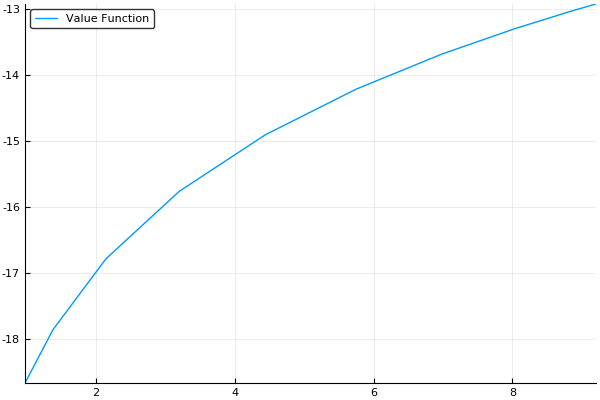

In [24]:
plot(K, Ψ * ν, label="Value Function")

In [27]:
Ψ * ν

10-element Array{Float64,1}:
 -18.6612
 -17.8533
 -16.7777
 -15.7588
 -14.9034
 -14.2155
 -13.6825
 -13.2976
 -13.0469
 -12.9235

In [26]:
ν

10-element Array{Float64,1}:
 -15.112     
   2.69213   
  -0.640543  
   0.208069  
  -0.0777003 
   0.0304588 
  -0.0123556 
   0.00602886
  -0.00329544
   0.00114639

## MPEC

In [8]:
using JuMP
using Ipopt

In [9]:
function f(k, α, A)
    A*k^α
end

function f_prime(k, α, A)
    A*α*k^(α-1)
end

f_prime (generic function with 2 methods)

In [10]:
basis = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))

1 dimensional Basis on the hypercube formed by (0.9257976178276875,) × (9.257976178276875,).
Basis families are Cheb


In [11]:
K = nodes(basis)[1]
Ψ = BasisMatrix(basis, Expanded(), K).vals[1];

### Variante A

EE on a grid as a constraint is problematic since next period's capital is a function of deep parameters!
filling in realized consumption next period is infeasible (or maybe some form of rational expectations?!) in stochastic models!

In [12]:
m = Model(solver=IpoptSolver(print_level=5, max_iter = 500))

@variable(m, β, start = 1)
@variable(m, δ, start = 1)
@variable(m, α, start = 0.6)
@variable(m, A, start = 1)
@variable(m, γ, start = 1)

@variable(m, coeff[1:10], start = 0)
setvalue(coeff[1], 1)

@variable(m, predictedK[2:100], start = 1)
@variable(m, predictedC[1:100], start = 1)
@variable(m, EEerror[1:99])

JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)

Φ = BasisMatrix(basis, Expanded(), dataK).vals[1];

In [13]:
@NLconstraint(m, LOM[t=2:100], predictedK[t] == f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1]);
@NLconstraint(m, consumption[t=1:100], predictedC[t] == sum(Φ[t, k] * coeff[k] for k in 1:10))

@NLconstraint(m, fixedpoint[t=1:99], EEerror[t] == u_crra_prime(predictedC[t], γ) -
    β * u_crra_prime(dataC[t+1], γ) * (f_prime(predictedK[t+1], α, A) + 1-δ));

In [14]:
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) + 
    sum((dataK[t] - predictedK[t])^2 for t in 2:100) + sum(EEerror[t]^2 for t in 1:99))

In [15]:
solve(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2288
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      313
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

:Optimal

In [16]:
getvalue(predictedK).innerArray

99-element Array{Float64,1}:
 1.21283
 1.42073
 1.62156
 1.81408
 1.99759
 2.17174
 2.33639
 2.49163
 2.63764
 2.77471
 2.90316
 3.02337
 3.13576
 ⋮      
 4.62445
 4.62483
 4.62519
 4.62551
 4.62582
 4.6261 
 4.62636
 4.6266 
 4.62682
 4.62703
 4.62722
 4.6274 

In [17]:
[getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)]

5-element Array{Float64,1}:
 0.950001 
 0.0499987
 0.299998 
 0.999999 
 1.99991  

In [18]:
getvalue(coeff) - true_coeff

10-element Array{Float64,1}:
 -0.236393  
 -0.400215  
 -0.225332  
 -0.0429154 
  0.0695975 
  0.0957278 
  0.0692258 
  0.0331543 
  0.0103012 
  0.00170368


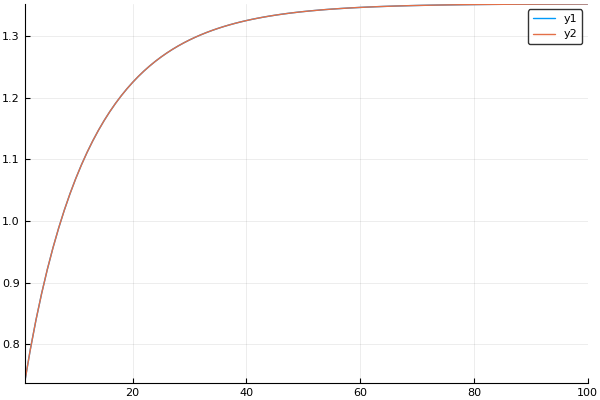

In [19]:
plot(hcat(getvalue(predictedC), dataC))


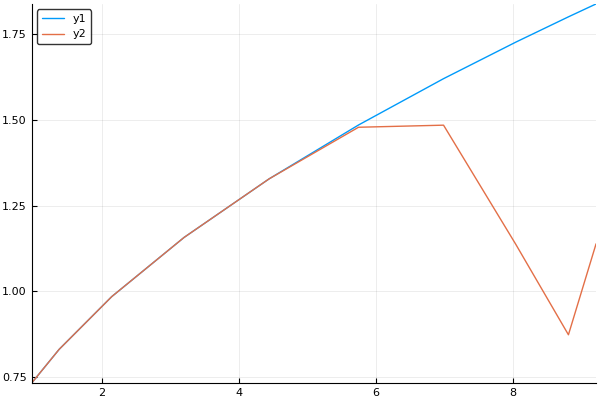

In [20]:
plot(K, hcat(Ψ * true_coeff, Ψ * getvalue(coeff)))

The approximation is only good within the actually observed data, that is very bad! Macro is about what agent think can happen and what they would do.

### Variante B
use 10 EE as constraints and gap between predition and data as objective function!
makes more sense in order to target moments of data more easily
but auto will not be able to differentiate through the function that creats the basis matrix!

In [22]:
u_crra_prime(c, γ) = begin
    if (c <= 0)
        return -1000000.
        else
        return c.^-γ
    end
end

u_crra_prime_inv(u, γ) = begin
    if (u <= 0)
        return -100000.
    else
        return u.^(-1/γ) 
    end
end

function f(k, α, A)
    A*k^α
end

function f_prime(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 2 methods)

In [23]:
k_stst = 4.628988089138438 #reference point of the grid
basis = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
K = nodes(basis)[1] #grid
Ψ = BasisMatrix(basis, Expanded(), K).vals[1] #\Psi(k)
Φ = BasisMatrix(basis, Expanded(), dataK).vals[1]

m = Model(solver=IpoptSolver(print_level=5, max_iter=500))

@variable(m, 0 <= β <= 1, start = 0.95)
@variable(m, 0 <= δ <= 1, start = 0.05)
@variable(m, 0 <= α <= 1, start = 0.3)
@variable(m, A >= 0, start = 1)
@variable(m, γ >= 0, start = 2)

#@variable(m, 0 <= β <= 1, start = 0.0)
#@variable(m, 0 <= δ <= 1, start = 0.00)
#@variable(m, 0 <= α <= 1, start = 0.9)
#@variable(m, A >= 0, start = 5)
#@variable(m, γ >= 0, start = 10)

@variable(m, θ[1:10], start = 0)
setvalue(θ[1], 0.4)

@variable(m, modelC[i=1:10], start = 1)
@variable(m, modelCprime[i=1:10], start = 1)
@variable(m, modelKprime[i=1:10], start = 1)

JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

In [24]:
function Ψprime(x, order)
    k_stst = 4.628988089138438
    a = 0.2*k_stst
    b = 2*k_stst
        
    z = (2/(b-a)) * (x-(a+b)/2)
    
    if (order == 1)
        return 1.
    elseif (order == 2)
        return z
    else

        out1 = 1.
        out2 = z
        out3 = 0.

        for j in 3:order
            out3 = 2. * z * out2 - out1
            out1 = out2
            out2 = out3
        end

        return out3
    end
end

Ψprime (generic function with 1 method)

In [25]:
JuMP.register(m, :Ψprime, 2, Ψprime, autodiff=true)

In [26]:
@NLconstraint(m, a[i=1:10], modelC[i] == sum(Ψ[i, k] * θ[k] for k in 1:10))
@NLconstraint(m, b[i=1:10], modelCprime[i] == sum(Ψprime(modelKprime[i], k) * θ[k] for k in 1:10))
@NLconstraint(m, c[i=1:10], modelKprime[i] == f(K[i], α, A) + (1-δ)*K[i] - modelC[i])

@NLconstraint(m, EE[i=1:10], modelC[i] == u_crra_prime_inv(
    β * u_crra_prime(modelCprime[i], γ) * (f_prime(modelKprime[i], α, A) + 1-δ), γ));

In [27]:
@NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])
@NLexpression(m, predictedC[t=1:100], sum(Φ[t, k] * θ[k] for k in 1:10));

In [28]:
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))

In [29]:
#@NLobjective(m, Min, (β-0.95)^2 + (δ-0.05)^2 + (α-0.3)^2 + (A-1)^2 + (γ-2)^2)

In [30]:
solve(m)

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      360
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       45
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:       40
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

:Optimal


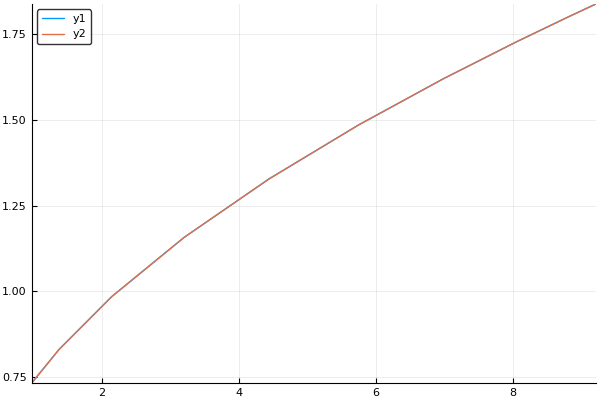

In [31]:
plot(K, hcat(Ψ * true_coeff, Ψ * getvalue(θ)))

In [32]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

(0.950000112562481, 0.05000066738305679, 0.3000008897589999, 1.0000005236181664, 2.0000023699700993)

In [33]:
d = JuMP.NLPEvaluator(m)
MathProgBase.initialize(d, [:Grad, :Jac])

In [34]:
g = zeros(40)
MathProgBase.eval_g(d, g, m.colVal)

In [35]:
g[31:end]

10-element Array{Float64,1}:
  0.0        
 -1.11022e-16
  0.0        
  0.0        
  0.0        
 -2.22045e-16
  0.0        
 -4.44089e-16
 -2.22045e-16
 -2.22045e-16

In [36]:
Ψ * getvalue(θ) .- u_crra_prime_inv.(
    getvalue(β) * u_crra_prime.(getvalue(modelCprime), getvalue(γ)) .* (f_prime.(getvalue(modelKprime), getvalue(α), getvalue(A)) + 1-getvalue(δ)), getvalue(γ))

10-element Array{Float64,1}:
  1.11022e-16
 -1.11022e-16
  1.11022e-16
  4.44089e-16
  4.44089e-16
 -6.66134e-16
  2.22045e-16
 -4.44089e-16
  2.22045e-16
 -2.22045e-16

In [37]:
getvalue(θ)

10-element Array{Float64,1}:
  1.35054    
  0.544286   
 -0.0634736  
  0.0167686  
 -0.00554683 
  0.00203288 
 -0.000791508
  0.000351973
 -0.000172349
  5.71703e-5 

In [38]:
a = getvalue(θ)

10-element Array{Float64,1}:
  1.35054    
  0.544286   
 -0.0634736  
  0.0167686  
 -0.00554683 
  0.00203288 
 -0.000791508
  0.000351973
 -0.000172349
  5.71703e-5 

In [39]:
#solve

    k_stst = steady_state_k(model)

    basis = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))

    Ψ = BasisMatrix(basis, Expanded()).vals[1]
    K = nodes(basis)[1]

10-element Array{Float64,1}:
 0.977089
 1.37987 
 2.14602 
 3.20052 
 4.44017 
 5.74361 
 6.98325 
 8.03776 
 8.8039  
 9.20668 

In [40]:
β, α, A, δ, γ

(β, α, A, δ, γ)